In [1]:
%load_ext autoreload 
%autoreload 2

In [34]:
import pandas as pd
import plotly.express as px
from collections import defaultdict

from privacypacking.budget import RenyiBudget
from privacypacking.budget.curves import GaussianCurve, BoundedOneShotSVT, PureDPtoRDP_loose, PureDPtoRDP
from privacypacking.utils.plot import df_normalized_curves

In [15]:
block.alphas

[1.5, 1.75, 2, 2.5, 3, 4, 5, 6, 8, 16, 32, 64]

## Naively paying for each query

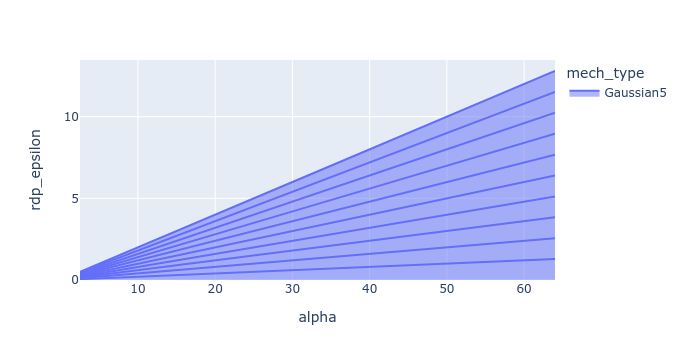

In [27]:
curves = {}
for i in range(10):
    curves[f"Gaussian5-{i}"] =  GaussianCurve(sigma=5)
    

df = df_normalized_curves(curves)
px.area(df, x="alpha", y="rdp_epsilon", color="mech_type", line_group="mech_name")

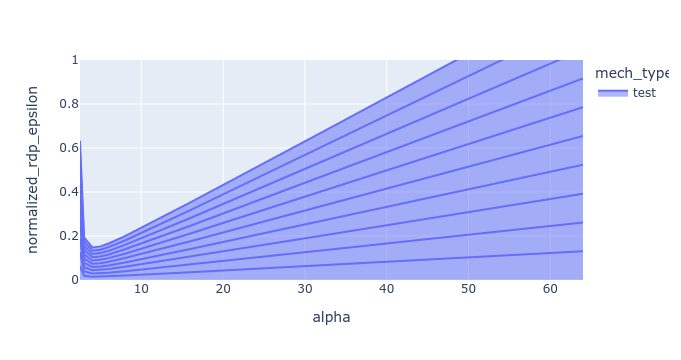

In [21]:
px.area(df, x="alpha", y="normalized_rdp_epsilon", color="mech_type", line_group="mech_name", range_y=[0,1])

## Gaussian sparse vector with RDP

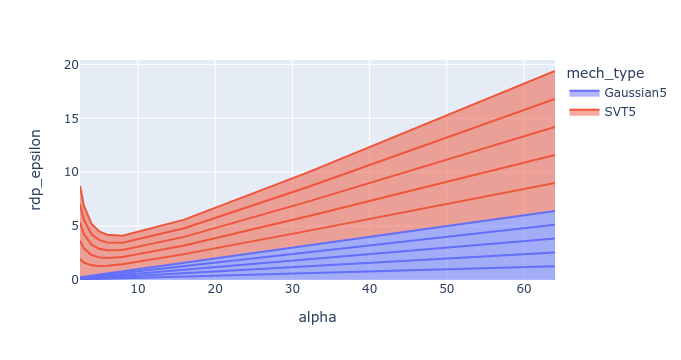

In [30]:
# 5 hard queries, and only easy queries after that
curves = {}
for i in range(5):
    curves[f"Gaussian5-{i}"] =  GaussianCurve(sigma=5)
    curves[f"SVT5-{i}"] = BoundedOneShotSVT(ro=5, nu=5, kmax=10)
df = df_normalized_curves(curves)
px.area(df, x="alpha", y="rdp_epsilon", color="mech_type", line_group="mech_name")

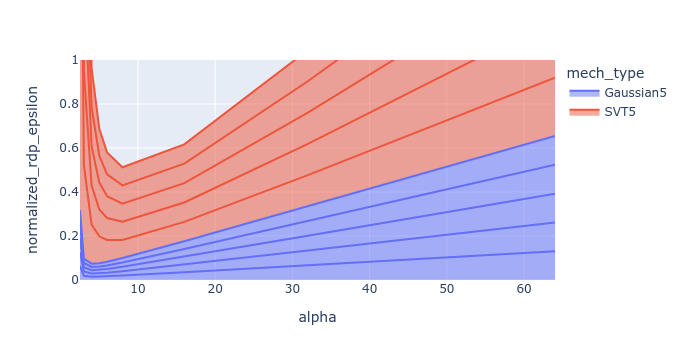

In [31]:
px.area(df, x="alpha", y="normalized_rdp_epsilon", color="mech_type", line_group="mech_name", range_y=[0,1])

In [49]:
BoundedOneShotSVT(ro=5, nu=5, kmax=10).epsilon(alpha=4) / GaussianCurve(sigma=5).epsilon(alpha=4)

11.991230303326544

In [51]:
# This is a sprase vector that can only answer 2 queries! Not very useful. But still expensive...
BoundedOneShotSVT(ro=5, nu=5, kmax=2).epsilon(alpha=4) / GaussianCurve(sigma=5).epsilon(alpha=4)

6.57755120278379

## Standard (Laplace) sparse vector, converted to RDP with a pure DP upper bound

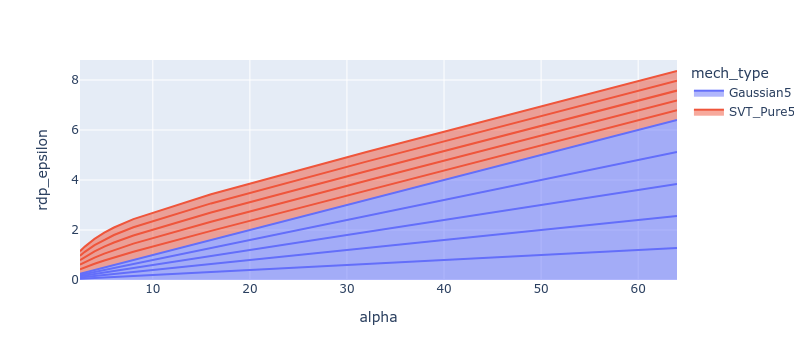

In [43]:
curves = {}
for i in range(5):
    curves[f"Gaussian5-{i}"] =  GaussianCurve(sigma=5)
    curves[f"SVT_Pure5-{i}"] = PureDPtoRDP(1/5+1/5)
df = df_normalized_curves(curves)
px.area(df, x="alpha", y="rdp_epsilon", color="mech_type", line_group="mech_name")

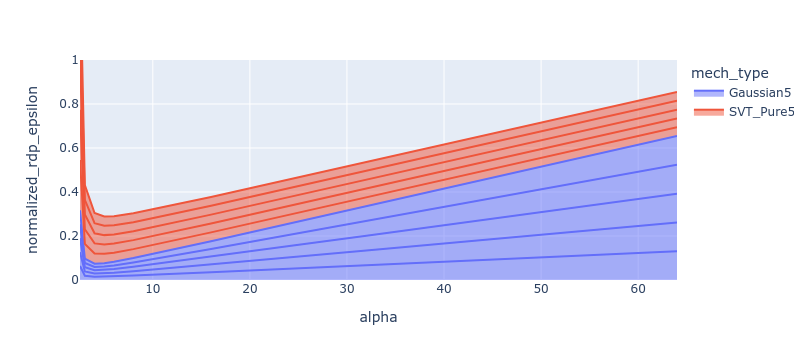

In [44]:
px.area(df, x="alpha", y="normalized_rdp_epsilon", color="mech_type", line_group="mech_name", range_y=[0,1])

In [47]:
PureDPtoRDP(1/5+1/5).epsilon(alpha=4) / GaussianCurve(sigma=5).epsilon(alpha=4)

3.1084065578667452

Roughly speaking, the sparse vector can save budget if for each hard query we have 3 easy queries. This is without considering the additional error induced by optimistic easy queries.

Question: Laplace sparse vector does not seem that bad, and certainly better than the Gaussian sparse vector for our parameters. Why isn't it evaluated in the RDP SVT paper? Well, they indeed evaluate it, and also find that Gaussian with c=1 is worse than Laplace. But Gaussian with c>1 can sometimes be better than Laplace (rarely), and Stage-wise generalized SVT outperforms any other alternative. 

It really depends on why parameters you are using. Large T works well with Gaussian since the tail is large. Gaussian SVT also has this additional k_max parameter. I think that it's safe to stick to Laplace SVT with RDP for now, it's simple and reasonably strong.

## Appendix: Comparing two conversions from Pure DP to RDP

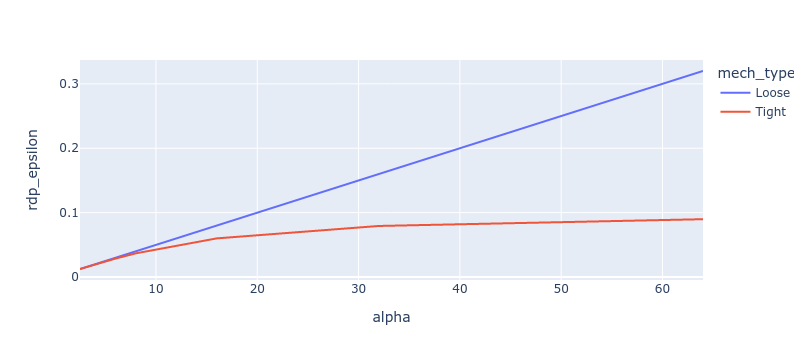

In [41]:
curves = {}
epsilon = 0.1
curves[f"Loose"] = PureDPtoRDP_loose(epsilon=epsilon)
curves[f"Tight"] = PureDPtoRDP(epsilon=epsilon)
df = df_normalized_curves(curves)
px.line(df, x="alpha", y="rdp_epsilon", color="mech_type", line_group="mech_name")

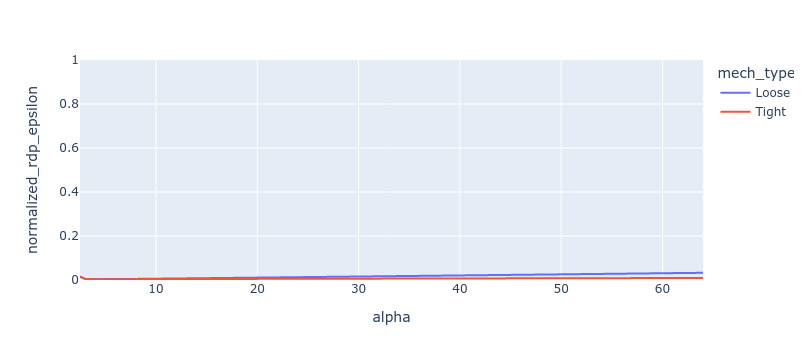

In [42]:
px.line(df, x="alpha", y="normalized_rdp_epsilon", color="mech_type", line_group="mech_name", range_y=[0,1])